Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

Using TensorFlow backend.


## Define the game environment and replay classes
The idea in this Catch game is that there is fruit falling, and the user gets to move a basket so that they catch the fruit. If they catch it, they win and the game is over. If they miss it, they lose and the game is over. We are trying to teach the computer to play this game.

In [2]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets

##  Functions for creating, training, and visualizing the model

In [3]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # Define environment/game
    env = Catch(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    catch_count = 0
    for episode in range(num_episodes):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)
            if reward == 1:
                catch_count += 1

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            # get data updated based on the stored experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on the updated data
            loss += model.train_on_batch(inputs, targets)

            starting_observation = new_observation # for next time through the loop

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Catch count {}".format(episode, num_episodes-1, loss, catch_count))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    observations = []
    for _ in range(num_games):
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [4]:
model, env, exp_replay = build_model()

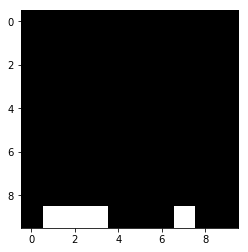

In [5]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episode 0000/0999 | Loss 0.0057 | Catch count 0
Episode 0001/0999 | Loss 0.2673 | Catch count 1
Episode 0002/0999 | Loss 0.2383 | Catch count 1
Episode 0003/0999 | Loss 0.1966 | Catch count 1
Episode 0004/0999 | Loss 0.2662 | Catch count 1
Episode 0005/0999 | Loss 0.2100 | Catch count 1
Episode 0006/0999 | Loss 0.1981 | Catch count 1
Episode 0007/0999 | Loss 0.2074 | Catch count 2
Episode 0008/0999 | Loss 0.2270 | Catch count 2
Episode 0009/0999 | Loss 0.1945 | Catch count 3
Episode 0010/0999 | Loss 0.2442 | Catch count 3
Episode 0011/0999 | Loss 0.2426 | Catch count 3
Episode 0012/0999 | Loss 0.1964 | Catch count 3
Episode 0013/0999 | Loss 0.1678 | Catch count 3
Episode 0014/0999 | Loss 0.1473 | Catch count 4
Episode 0015/0999 | Loss 0.1879 | Catch count 5
Episode 0016/0999 | Loss 0.2079 | Catch count 5
Episode 0017/0999 | Loss 0.1975 | Catch count 6
Episode 0018/0999 | Loss 0.1898 | Catch count 6
Episode 0019/0999 | Loss 0.1700 | Catch count 6
Episode 0020/0999 | Loss 0.2044 | Catch 

Episode 0168/0999 | Loss 0.1028 | Catch count 66
Episode 0169/0999 | Loss 0.1603 | Catch count 66
Episode 0170/0999 | Loss 0.1097 | Catch count 67
Episode 0171/0999 | Loss 0.1352 | Catch count 67
Episode 0172/0999 | Loss 0.1493 | Catch count 68
Episode 0173/0999 | Loss 0.1292 | Catch count 68
Episode 0174/0999 | Loss 0.1659 | Catch count 68
Episode 0175/0999 | Loss 0.1189 | Catch count 69
Episode 0176/0999 | Loss 0.1271 | Catch count 70
Episode 0177/0999 | Loss 0.1252 | Catch count 70
Episode 0178/0999 | Loss 0.0968 | Catch count 71
Episode 0179/0999 | Loss 0.1275 | Catch count 72
Episode 0180/0999 | Loss 0.0822 | Catch count 73
Episode 0181/0999 | Loss 0.1029 | Catch count 73
Episode 0182/0999 | Loss 0.0955 | Catch count 74
Episode 0183/0999 | Loss 0.0930 | Catch count 75
Episode 0184/0999 | Loss 0.1242 | Catch count 75
Episode 0185/0999 | Loss 0.1209 | Catch count 75
Episode 0186/0999 | Loss 0.1057 | Catch count 76
Episode 0187/0999 | Loss 0.1001 | Catch count 76
Episode 0188/0999 | 

Episode 0333/0999 | Loss 0.0459 | Catch count 160
Episode 0334/0999 | Loss 0.0425 | Catch count 161
Episode 0335/0999 | Loss 0.0360 | Catch count 161
Episode 0336/0999 | Loss 0.0455 | Catch count 162
Episode 0337/0999 | Loss 0.0298 | Catch count 163
Episode 0338/0999 | Loss 0.0262 | Catch count 163
Episode 0339/0999 | Loss 0.0263 | Catch count 163
Episode 0340/0999 | Loss 0.0255 | Catch count 164
Episode 0341/0999 | Loss 0.0317 | Catch count 164
Episode 0342/0999 | Loss 0.0329 | Catch count 165
Episode 0343/0999 | Loss 0.0251 | Catch count 166
Episode 0344/0999 | Loss 0.0311 | Catch count 167
Episode 0345/0999 | Loss 0.0322 | Catch count 167
Episode 0346/0999 | Loss 0.0365 | Catch count 167
Episode 0347/0999 | Loss 0.0307 | Catch count 168
Episode 0348/0999 | Loss 0.0462 | Catch count 169
Episode 0349/0999 | Loss 0.0384 | Catch count 169
Episode 0350/0999 | Loss 0.0339 | Catch count 170
Episode 0351/0999 | Loss 0.0342 | Catch count 171
Episode 0352/0999 | Loss 0.0325 | Catch count 171


Episode 0497/0999 | Loss 0.0249 | Catch count 267
Episode 0498/0999 | Loss 0.0223 | Catch count 268
Episode 0499/0999 | Loss 0.0235 | Catch count 269
Episode 0500/0999 | Loss 0.0228 | Catch count 270
Episode 0501/0999 | Loss 0.0231 | Catch count 271
Episode 0502/0999 | Loss 0.0142 | Catch count 271
Episode 0503/0999 | Loss 0.0178 | Catch count 272
Episode 0504/0999 | Loss 0.0174 | Catch count 272
Episode 0505/0999 | Loss 0.0251 | Catch count 273
Episode 0506/0999 | Loss 0.0169 | Catch count 274
Episode 0507/0999 | Loss 0.0182 | Catch count 275
Episode 0508/0999 | Loss 0.0190 | Catch count 276
Episode 0509/0999 | Loss 0.0216 | Catch count 277
Episode 0510/0999 | Loss 0.0198 | Catch count 277
Episode 0511/0999 | Loss 0.0229 | Catch count 278
Episode 0512/0999 | Loss 0.0172 | Catch count 279
Episode 0513/0999 | Loss 0.0206 | Catch count 280
Episode 0514/0999 | Loss 0.0113 | Catch count 281
Episode 0515/0999 | Loss 0.0306 | Catch count 282
Episode 0516/0999 | Loss 0.0203 | Catch count 283


Episode 0661/0999 | Loss 0.0332 | Catch count 407
Episode 0662/0999 | Loss 0.0517 | Catch count 407
Episode 0663/0999 | Loss 0.0377 | Catch count 408
Episode 0664/0999 | Loss 0.0235 | Catch count 409
Episode 0665/0999 | Loss 0.0465 | Catch count 409
Episode 0666/0999 | Loss 0.0631 | Catch count 410
Episode 0667/0999 | Loss 0.0571 | Catch count 411
Episode 0668/0999 | Loss 0.0478 | Catch count 412
Episode 0669/0999 | Loss 0.0389 | Catch count 412
Episode 0670/0999 | Loss 0.0331 | Catch count 413
Episode 0671/0999 | Loss 0.0588 | Catch count 414
Episode 0672/0999 | Loss 0.0344 | Catch count 415
Episode 0673/0999 | Loss 0.0637 | Catch count 415
Episode 0674/0999 | Loss 0.0266 | Catch count 416
Episode 0675/0999 | Loss 0.0395 | Catch count 417
Episode 0676/0999 | Loss 0.0522 | Catch count 418
Episode 0677/0999 | Loss 0.0276 | Catch count 419
Episode 0678/0999 | Loss 0.0519 | Catch count 419
Episode 0679/0999 | Loss 0.0543 | Catch count 420
Episode 0680/0999 | Loss 0.0365 | Catch count 421


Episode 0825/0999 | Loss 0.0088 | Catch count 555
Episode 0826/0999 | Loss 0.0092 | Catch count 555
Episode 0827/0999 | Loss 0.0124 | Catch count 555
Episode 0828/0999 | Loss 0.0154 | Catch count 556
Episode 0829/0999 | Loss 0.0159 | Catch count 557
Episode 0830/0999 | Loss 0.0138 | Catch count 558
Episode 0831/0999 | Loss 0.0130 | Catch count 559
Episode 0832/0999 | Loss 0.0118 | Catch count 560
Episode 0833/0999 | Loss 0.0109 | Catch count 561
Episode 0834/0999 | Loss 0.0120 | Catch count 562
Episode 0835/0999 | Loss 0.0090 | Catch count 563
Episode 0836/0999 | Loss 0.0099 | Catch count 564
Episode 0837/0999 | Loss 0.0074 | Catch count 565
Episode 0838/0999 | Loss 0.0106 | Catch count 566
Episode 0839/0999 | Loss 0.0198 | Catch count 567
Episode 0840/0999 | Loss 0.0166 | Catch count 568
Episode 0841/0999 | Loss 0.0096 | Catch count 569
Episode 0842/0999 | Loss 0.0108 | Catch count 570
Episode 0843/0999 | Loss 0.0185 | Catch count 571
Episode 0844/0999 | Loss 0.0086 | Catch count 572


Episode 0989/0999 | Loss 0.0077 | Catch count 706
Episode 0990/0999 | Loss 0.0058 | Catch count 707
Episode 0991/0999 | Loss 0.0089 | Catch count 708
Episode 0992/0999 | Loss 0.0074 | Catch count 709
Episode 0993/0999 | Loss 0.0086 | Catch count 710
Episode 0994/0999 | Loss 0.0075 | Catch count 711
Episode 0995/0999 | Loss 0.0065 | Catch count 712
Episode 0996/0999 | Loss 0.0045 | Catch count 713
Episode 0997/0999 | Loss 0.0055 | Catch count 714
Episode 0998/0999 | Loss 0.0045 | Catch count 715
Episode 0999/0999 | Loss 0.0043 | Catch count 716


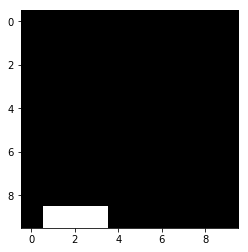

In [6]:
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works, using more of a policy gradient strategy.

In [ ]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.catch_number = 0
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air, while
        tallying the number of times the fruit is caught and resetting it when it is.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) == -1:
                return -1 # it dropped the fruit
            else:
                reset()
                catch_number += 1
                return 1 # it caught the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward == -1) # if the reward is -1, the fruit was dropped
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets